<a href="https://colab.research.google.com/github/harvardnlp/namedtensor/blob/master/NamedTensor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensor Considered Harmful

*Alexander Rush* - @harvardnlp

<i>
TL;DR: Despite its ubiquity in deep learning, the Tensor object is broken. It forces bad programming habits such as exposing private dimensions, broadcasting based on absolute position,  and keeping type information in uncheckable documentation.  This post presents a proof-of-concept of a simple alternative approach, **named tensors**, that forces all dimensions of a tensor to have a human-readable name. This change eliminates the need for indexing, dim/axis arguments, tricks like einsum, and gives easier dynamic error checking. The prototype **PyTorch library** accompanying this blog post is available at [harvardnlp/namedtensor](https://github.com/harvardnlp/NamedTensor).
</i>

* Table of Contents                                                                                                                                                                                             
{:toc} 

In [0]:
# Setup
!rm -fr NamedTensor/; git clone -q https://github.com/harvardnlp/NamedTensor.git
!cd NamedTensor; pip install -q .  
!pip install -q torch numpy opt_einsum
import numpy 
import torch
from namedtensor import NamedTensor, ntorch
from namedtensor import _im_init
nt._im_init()

> Notes: 
> * Jon Malmaud points out that the [xarray](http://xarray.pydata.org/en/stable/) project has very similar goals as this note with the addition of extensive Pandas and scientific computing support. 

#  Tensor Traps

The Tensor, a multi-dimensional array, is the central object of deep learning frameworks such as Torch, TensorFlow and Chainer. 

In [73]:
ims = torch.tensor(numpy.load('NamedTensor/examples/test_images.npy'))
ims.shape

torch.Size([6, 96, 96, 3])

Tensors carry around an implied tuple of their dimension. Here there are 4, corresponding to *batch_size*, *height*, *width*, and *channels*. Most of the time you can figure this out by some comment in the code that looks like this:  

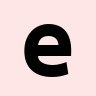

In [74]:
# batch_size x height x width x channels
ims[0]

These objects are concise, mathy, and facilitate efficient code, particularly on the GPU. However from a programming point of view they are inherently broken. The following are three traps that often come up.


## Trap 1: Private by Convention instead of Encapsulation

Code that manipulates tensors does so by indexing. If you want to rotate the image you read the comment, decide what needs to get changed and alter it. 

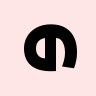

In [75]:
def rotate(ims):
    # batch_size x height x width x channels
    rotated = ims.transpose(1, 2)
    
    # batch_size x width x height x channels
    return rotated
rotate(ims)[0]

This code is simple and in theory well documented. However, it does not reflect the semantics of the underlying function. The property of rotation is independent of the batch, or for that matter, the channels. The function should not have to account for these dimensions in determining the dimensions to alter. 

This leads to two problems. FIrst, it's quite worrisome that if we pass in a singleton image this function runs fine but fails to work. 

In [76]:
rotate(ims[0]).shape

torch.Size([96, 3, 96])

However, even more worrisome is that the function may actually use the batch dimensions by mistake and mix together properties of different images. This can lead to nasty bugs that would be easy to avoid if this dimension was hidden from the code. 

## Trap 2: Broadcasting by Alignment instead of Semantics

The most useful aspect of Tensors is that they can quickly do array operations without directly requiring for loops. For this to work dimensions need to be directly aligned so that they can be broadcasts. Again this is done by convention and code documentation that makes it "easy" to line up dimensions. For instance, let's assume we want to apply a mask to the above image. 


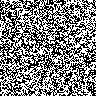

In [77]:
# height x width
mask = torch.randint(0, 2, [96, 96]).byte()
mask

In [78]:
try:
    ims.masked_fill(mask, 0)
except RuntimeError:
    print("Broadcasing fail", mask.shape, ims.shape)

Broadcasing fail torch.Size([96, 96]) torch.Size([6, 96, 96, 3])


This fails because even though we knew that we were building a *height* and *width* shaped mask, the rules of broadcasting do not have the correct semantics. To make this work, you are encouraged to use either `view` or `squeeze` my least favorite functions.  

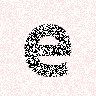

In [79]:
# either 
mask = mask.unsqueeze(-1)
# or 
mask = mask.view(96, 96, 1)

# height x width x channels
ims.masked_fill(mask, 1)[0]

Note we do not need to do this for the left-most dimensions so there is a bit of abstraction here.  However reading through real code, dozens of right side `view`s and `squeeze`s become completely unreadable.

## Trap 3: Accessors in Comments instead of Code



It is possible that you look at the top two issues and think that as long as you are careful, these issues will be caught by run time errors. 
However, even well used the combination of broadcasting and indexing can lead to problems that are very tough to catch.  

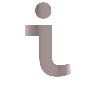

In [80]:

a = ims[1].mean(2, keepdim=True)
# height x width x 1

# (Lots of code in between)
#  .......................

# Code comment explaining what should be happening.
dim = 1
b = a + ims.mean(dim, keepdim=True)[0]


# (Or maybe should be a 2? or a 0?)
index = 2
b = a + ims.mean(dim, keepdim=True)[0]
b

Here we assume that the coder is trying to combine two tensor using both reduction operations and dimension indexing. (Honestly at this point I have forgetten the dimensions stand for). 

The main point though is that this code will run fine for whatever value `dim` is given. The comment here might descibe what is happening but the code itself doesn't throw a run time error. 

# Named Tensor: A Prototype

Based on these issues, I think deep learning code should move to a better central object. There are several of these proposed. Here for fun, I will develop a new prototype. I have the following goals. 

*1) Dimensions with have human-readable names.*

*2) No function should have `dim` argument.*

*3) Broadcast by dimension names.*

*4) Transposition should be explicit.*

*5) Avoid dimension indexing. *

*6) Private dimensions should be protected.*





To experiment with these ideas I have built a library known as `NamedTensor`. Currently it is PyTorch specific, but in theory a similar idea could be used in other frameworks. The code is available at [github.com/harvardnlp/namedtensor](https://github.com/harvardnlp/namedtensor). 

## Proposal 1: Assigning Names

The core of the library is an object that wraps a tensor and provides names for each dimension. Here we simply wrap a given torch tensor with dimension names.

In [81]:
named_ims = NamedTensor(ims, "batch height width channels")
named_ims.named_shape

OrderedDict([('batch', 6), ('height', 96), ('width', 96), ('channels', 3)])

Alternatively the library has wrappers for the pytorch constructors to turn them into named tensors. 

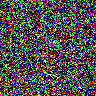

In [113]:
ex = ntorch.randn(dict(height=96, width=96, channels=3))
ex

Most simple operations simply keep around the named tensor properties. 

In [0]:
ex.log()

# or 

ntorch.log(ex)

None

## Proposal 2: Accessors and Reduction

The first benefit of names comes from the ability to replace the need for `dim` and `axis` style arguments entirely. For example, lets say we wanted to sort each column. 

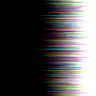

In [122]:
sortex, _ = ex.sort("width")
sortex

Another common operation is a *reduction*  where one or more dimensions is pooled out.   

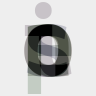

In [125]:
named_ims.mean("batch")

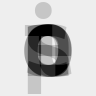

In [126]:
named_ims.mean("batch channels")

## Proposal 3: Broadcasting and Contraction

The names that are provided also provide the basis for broadcasting operations. When there is a binary operations between two named tensors they first ensure that all dimension are matched in name and then apply standard broadcasting. To demonstrate let's return to the masking example above. Here we simply declare the names of the dimensions of our mask, and ask the library to figure out the broadcasting. 

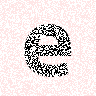

In [133]:
im = NamedTensor(ims[0], "height width channels")
im2 = NamedTensor(ims[1], "height width channels")

mask = NamedTensor(torch.randint(0, 2, [96, 96]).byte(), "height width")
im.masked_fill(mask, 1)

Similar operations can be used for standard matrix operations such as addition and multiplication.

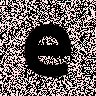

In [132]:
im * mask.double()

A more general feature is the `contract` method for tensor contraction between name tensors. Tensor contraction, the machinery behind `einsum`, is an elegant way of thinking about generalizations of dot-products, matrix-vector products, matrix-matrix products, etc.

In [134]:

# Runs torch.einsum(ijk,ijk->jk, tensor1, tensor2)
print(im.contract("height", im2).named_shape)

# Runs torch.einsum(ijk,ijk->il, tensor1, tensor2)
print(im.contract("width", im2).named_shape)

# Runs torch.einsum(ijk,ijk->l, tensor1, tensor2)
print(im.contract("height width", im2).named_shape)


OrderedDict([('width', 96), ('channels', 3)])
OrderedDict([('height', 96), ('channels', 3)])
OrderedDict([('channels', 3)])


Similar notation can be used for sparse indexing (inspired by the [einindex](https://pypi.org/project/einindex/) library). This is useful for embedding lookups and other sparse operations. 

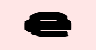

In [136]:
pick, _ = NamedTensor(torch.randint(0, 96, [50]).long(), "lookups") \
             .sort("lookups")

# Select 50 random rows.
im.index_select("height", pick)

## Proposal 4: Shifting Dimensions 

Behind the scenes all of the named tensors are acting as tensor objects. As such thing like order and stride of dimensions does matter. Operations like `transpose` and `view` are crucial for maintaining this, but are unfortunately quite error-prone. 

Instead consider a domain specific langauge `shift` that borrows heavily from the Alex Rogozhnikov's excellent [einops](https://github.com/arogozhnikov/einops) package.
 

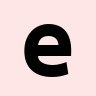

In [137]:
tensor = NamedTensor(ims[0], "h w c")
tensor

Standard calls to shift transpose dimensions.

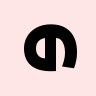

In [138]:
tensor.shift("w h c")

Calls with of the form "a -> (b c)" split dimensions, whereas "(a b) -> c" merge them. 

In [139]:
tensor = NamedTensor(ims[0], "h w c")
tensor.shift('h -> (height q)', height=8).named_shape

OrderedDict([('height', 8), ('q', 12), ('w', 96), ('c', 3)])

In [140]:
tensor = NamedTensor(ims, 'b h w c')
tensor.shift('(b h) -> bh').named_shape


OrderedDict([('bh', 576), ('w', 96), ('c', 3)])

Shifts can be chained in the same function.

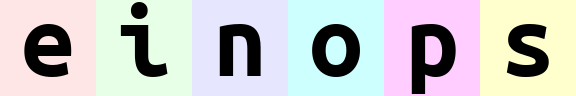

In [95]:
tensor.shift('(b w) -> bw', 'h bw c')


Just for fun, here are some of the crazier examples from *einops* in this notation.

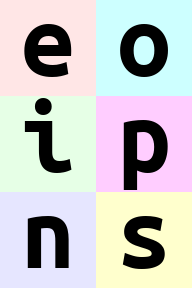

In [96]:
tensor.shift("b -> (b1 b2)", '(b2 h) -> a', '(b1 w) -> d', 'a d c', b1=2)

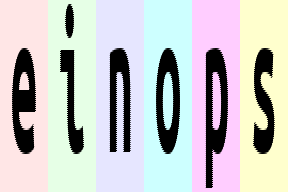

In [97]:
tensor.shift('w -> (w w2)', '(h w2) -> a', '(b w) -> d', 'a d c', w2=2)

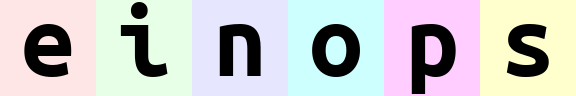

In [98]:
tensor.shift('(b w) -> a', 'h a c')

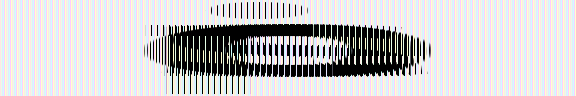

In [99]:
tensor.shift('(w b) -> a', 'h a c')

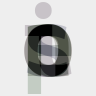

In [100]:
tensor = NamedTensor(ims, 'b h w c')
tensor.mean('b')

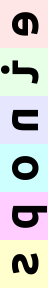

In [101]:
tensor = NamedTensor(ims, 'b h w c')
tensor.shift("h -> (h h2)", "w -> (w w2)", h2=2, w2=2).mean("h2 w2").shift("(b w) -> bw")

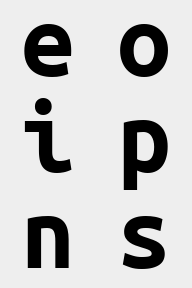

In [141]:
tensor = NamedTensor(ims, 'b h w c')
tensor.shift("b -> (b1 b2)", b1 = 2).mean('c').shift("(b1 w) -> bw", "(b2 h) -> bh", 'bh bw')


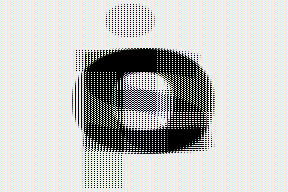

In [103]:
tensor.shift('b -> (b1 b2)', '(h b1) -> h', '(w b2) -> w', b1=2)

## Proposal 5: Ban Indexing


Generally indexing is discouraged in this named tensor paradigm. Instead use functions like `index_select` above.

There are some useful named alternative functions pulled over from torch. For example `unbind` pulls apart a dimension to a tuple.


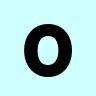

In [104]:
tensor = NamedTensor(ims, 'b h w c')

# Returns a tuple
images = tensor.unbind("b")
images[3]

The function `get` directly selects a slice of from a named dimension.

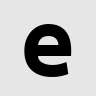

In [105]:
# Returns a tuple
images = tensor.get("b", 0).unbind("c")
images[1]

Finally `narrow` can be used to replace fancy indexing. However you must give a new dim name (since it can no longer broadcast).

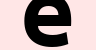

In [106]:
tensor.narrow( "h -> narrowedheight", 30, 50).get("b", 0)

## Proposal 6: Private Dimensions

Finally named tensor attempts to let you directly hide dimensions that should not be accessed by internal functions. The function `mask_to` will keep around a left side mask that protects any earlier dimensions from manipulations by functions. The simplest example uses a mask to drop the `batch` dimension. 

In [107]:
def bad_function(x, y):
    # Accesses the private batch dimension
    return x.mean("batch")

x = ntorch.randn(dict(batch=10, height=100, width=100))
y = ntorch.randn(dict(batch=10, height=100, width=100))

try:
    bad_function(x.mask_to("batch"), y)
except RuntimeError as e:
    print("Error received:", e)

Error received: Dimension batch is masked


This is weak dynamic check and can be turned off by internal functions. In future versions, perhaps we can add function annotations to lift non-named functions to respect these properties. 

## Real-Example: Attention

To demonstrate why these choices lead to better encapsulation properties, let's consider a real-world deep learning example. 

This example was proposed by my colleague Tim Rocktashel in the blog post describing einsum (https://rockt.github.io/2018/04/30/einsum). Tim's code was proposed as a better alternative to raw PyTorch. While I agree that einsum is a step forward, it still falls into many of the traps described above. 




Consider the problem of neural attention, which requires computing,

\begin{align*}
\mathbf{M}_t &= \tanh(\mathbf{W}^y\mathbf{Y}+(\mathbf{W}^h\mathbf{h}_t+\mathbf{W}^r\mathbf{r}_{t-1})\otimes \mathbf{e}_L) & \mathbf{M}_t &\in\mathbb{R}^{k\times L}\\
\alpha_t &= \text{softmax}(\mathbf{w}^T\mathbf{M}_t)&\alpha_t&\in\mathbb{R}^L\\
\mathbf{r}_t &= \mathbf{Y}\alpha^T_t + \tanh(\mathbf{W}^t\mathbf{r}_{t-1})&\mathbf{r}_t&\in\mathbb{R}^k
\end{align*}

First we setup the parameters. 

In [0]:
def random_ntensors(names, num=1, requires_grad=False):
    tensors = [ntorch.randn(names, requires_grad=requires_grad)
               for i in range(0, num)]
    return tensors[0] if num == 1 else tensors

class Param:
    def __init__(self, in_hid, out_hid):
        torch.manual_seed(0)
        self.WY, self.Wh, self.Wr, self.Wt = \
            random_ntensors(dict(inhid=in_hid, outhid=out_hid),
                            num=4, requires_grad=True)
        self.bM, self.br, self.w = \
            random_ntensors(dict(outhid=out_hid), 
                            num=3,
                            requires_grad=True)
        

Now consider the tensor-based einsum implementation of this function. 

In [0]:
# Einsum Implementation
import torch.nn.functional as F
def einsum_attn(params, Y, ht, rt1):
    # -- [batch_size x hidden_dimension]
    tmp = torch.einsum("ik,kl->il", [ht, params.Wh.tensor]) + \
          torch.einsum("ik,kl->il", [rt1, params.Wr.tensor])

    Mt = torch.tanh(torch.einsum("ijk,kl->ijl", [Y, params.WY.tensor]) + \
                tmp.unsqueeze(1).expand_as(Y) + params.bM.tensor)
    # -- [batch_size x sequence_length]
    at = F.softmax(torch.einsum("ijk,k->ij", [Mt, params.w.tensor]), dim=-1)

    # -- [batch_size x hidden_dimension]
    rt = torch.einsum("ijk,ij->ik", [Y, at]) + \
         torch.tanh(torch.einsum("ij,jk->ik", [rt1, params.Wt.tensor]) + 
                    params.br.tensor)

    # -- [batch_size x hidden_dimension], [batch_size x sequence_dimension]
    return rt, at

This implementation is an improvement over the naive PyTorch implementation. It removes many of the 
views and transposes that would be necessary to make this work. *However, it still uses `squeeze`, references the private batch dim, and usees comments that are not enforced.*

Consider instead the `namedtensor` version: 

In [0]:
def namedtensor_attn(params, Y, ht, rt1):
    tmp = ht.contract("inhid", params.Wh) + rt1.contract("inhid", params.Wr)
    at = ntorch.tanh(Y.contract("inhid", params.WY) + tmp + params.bM) \
         .contract("outhid", params.w) \
         .softmax("seqlen")

    rt = Y.contract("seqlen", at).shift("inhid -> (outhid)") + \
         ntorch.tanh(rt1.contract("inhid", params.Wt) + params.br)
    return rt, at


This code avoids all three traps.

(Trap 1) The code never mentions the `batch` dim.

(Trap 2) All broadcasting is done directly with contractions, there are no views.

(Trap 3) Operations across dims are explicit. For instance, the softmax is clearly over the seqlen. 

In [0]:
# Run Einsum
in_hid = 7; out_hid = 7
Y = torch.randn(3, 5, in_hid)
ht, rt1 = torch.randn(3, in_hid), torch.randn(3, in_hid)
params = Param(in_hid, out_hid)
r, a = einsum_attn(params, Y, ht, rt1)

# Run Named Tensor (hiding batch)
Y = NamedTensor(Y, "batch seqlen inhid", mask=1)
ht = NamedTensor(ht, "batch inhid", mask=1)
rt1 = NamedTensor(rt1, "batch inhid", mask=1)
nr, na = namedtensor_attn(params, Y, ht, rt1)

## Call to Action

Tools for deep learning help researchers implement standard models, but they also impact what researchers try. Current models can be built fine with the tools we have, but the programming practices are not going to scale to new models. 

(For instance, one space we have been working on recently is discrete latent variable models which often have many problem specific variables each with their own variable dimension. This setting breaks the current tensor paradigm almost immediately. )

This blog post is just a prototype of where this approach could go. If you are interested, I would love contributors to the build out this library properly. Some ideas if you want to send a PR to  [namedtensor](https://github.com/harvardnlp/NamedTensor). Some ideas:

1) **Extending beyond PyTorch**: Can we generalize this approach in a way that supports NumPy and Tensorflow?  


2) **Interacting with PyTorch Modules**: Can we "lift" PyTorch modules with type annotations, so that we know how they change inputs?


3) **Error Checking**: Can we add annotations to functions giving pre- and post -conditions so that dimensions are automatically checked.

